In [18]:
from functools import partial
from pathlib import Path

from matplotlib.pyplot import figure, plot
from torch import Tensor, histogram, tensor, use_deterministic_algorithms

from karpathy_series.makemore.bigrams import NGram
from karpathy_series.makemore.data import read_data
from karpathy_series.makemore.encoding.character import CharacterEncoder, CharacterSet, StringEncoder
from karpathy_series.makemore.components.neuro.functional import Functional
from karpathy_series.makemore.components.generation import NGramNetGenerator
from karpathy_series.makemore.components.networks.wavenet import Wavenet 
from karpathy_series.makemore.training.data import DataSplit, TrainingSequencer
from karpathy_series.makemore.training.learning import Learner, LearningRecord
from karpathy_series.makemore.util import set_rand_karpathy
from karpathy_series.makemore.components.models.model import Model
from karpathy_series.makemore.components.function.loss import CrossEntropyLoss
from karpathy_series.makemore.components.recorder import FreeRecorder

%matplotlib inline
use_deterministic_algorithms(True)
set_rand_karpathy()

In [2]:
data_path = Path("../../data/names.txt")
words = read_data(data_path)
char_set = CharacterSet.from_words(words)
char_encoder = CharacterEncoder.from_charset(char_set)
string_encoder = StringEncoder(char_encoder)

context_size = 8
embedding_dims = 10
hidden_dims = 200

n_gram_gen = partial(NGram.generate, context_size, char_set.pad)
ts = TrainingSequencer(string_encoder, char_encoder, n_gram_gen)
data_split = DataSplit.split(words, 80, 10, 10)
learning_sequence = ts.training_sequence(data_split.training, 32, True)
validation_set = ts.training_set(data_split.validation)

In [3]:
# g = rand_generator.manual_seed(seed)
wavenet = Wavenet.init(4, 2, char_encoder.size, embedding_dims, context_size, hidden_dims)
model = Model(wavenet, CrossEntropyLoss())
generator = NGramNetGenerator(char_set, string_encoder, char_encoder, wavenet, context_size)
learning_record = LearningRecord()
print(f"{wavenet.size()} parameters")
print(f"{wavenet.describe()} parameters")

171497 parameters
A wavenet model: Sequence [Embedding [27, 10], Move a factor of 2 from -2 to -1, Linear [20, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7f4ab6743ce0>, Move a factor of 2 from -2 to -1, Linear [400, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7f4ab6743ce0>, Move a factor of 2 from -2 to -1, Linear [400, 200] with bias, BatchNorm1d [200], Functional <built-in method tanh of type object at 0x7f4ab6743ce0>, Flatten last 2 dims, Linear [200, 27] with bias] parameters


In [4]:
example = tensor([[1, 2, 3, 4, 5, 6, 7, 8]]) 
m = example
print(m.shape)
for layer in wavenet.layers:
    m = layer(m)
    print(m.shape)

torch.Size([1, 8])
torch.Size([1, 8, 10])
torch.Size([1, 4, 20])
torch.Size([1, 4, 200])
torch.Size([1, 4, 200])
torch.Size([1, 4, 200])
torch.Size([1, 2, 400])
torch.Size([1, 2, 200])
torch.Size([1, 2, 200])
torch.Size([1, 2, 200])
torch.Size([1, 1, 400])
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
torch.Size([1, 1, 200])
torch.Size([1, 200])
torch.Size([1, 27])


In [5]:
print(wavenet.shape(example.shape))
print(wavenet.shape((8,)))

(1, 27)
(27,)


In [37]:
learner = Learner(model, 0.0005)
learning_record += learner(learning_sequence, epochs=10, report_epochs=1)

Epoch 1 is finished with loss =  1.7105
Epoch 2 is finished with loss =  1.8188
Epoch 3 is finished with loss =  1.7700
Epoch 4 is finished with loss =  1.7204
Epoch 5 is finished with loss =  1.7751
Epoch 6 is finished with loss =  1.8086
Epoch 7 is finished with loss =  1.6861
Epoch 8 is finished with loss =  1.8116
Epoch 9 is finished with loss =  1.7789
Epoch 10 is finished with loss =  1.9071


In [38]:
print(model(*validation_set))

tensor(1.9904, grad_fn=<NllLossBackward0>)


In [39]:
for k in range(20):
    print(generator())

rae
ameir
keyana
marletty
aveen
tynere
arien
juviera
adalyn
alfroni
tyris
martavious
astin
arisjah
fiancla
markenzle
kareed
sirchirlhaga
emery
rekhid


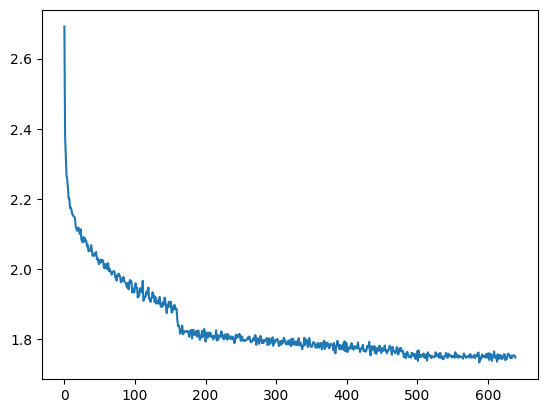

In [40]:
plot(tensor(learning_record.loss[: len(learning_record.loss) // 100 * 100]).view(-1, 100).mean(1))

In [33]:
wavenet_init = Wavenet.init(4, 2, char_encoder.size, embedding_dims, context_size, hidden_dims)
model_init = Model(wavenet_init, CrossEntropyLoss())
record = FreeRecorder()
loss = model_init(*next(learning_sequence()), record=record)
print(f"Step loss = {loss: .4f}")

Step loss =  3.6165


layer   4 Functional <built-in method tanh of type object at 0x7f4ab6743ce0>: mean -0.0047, std  0.5857, saturation  5.88%
layer   8 Functional <built-in method tanh of type object at 0x7f4ab6743ce0>: mean -0.0008, std  0.6053, saturation  5.05%
layer  12 Functional <built-in method tanh of type object at 0x7f4ab6743ce0>: mean -0.0034, std  0.6254, saturation  3.69%


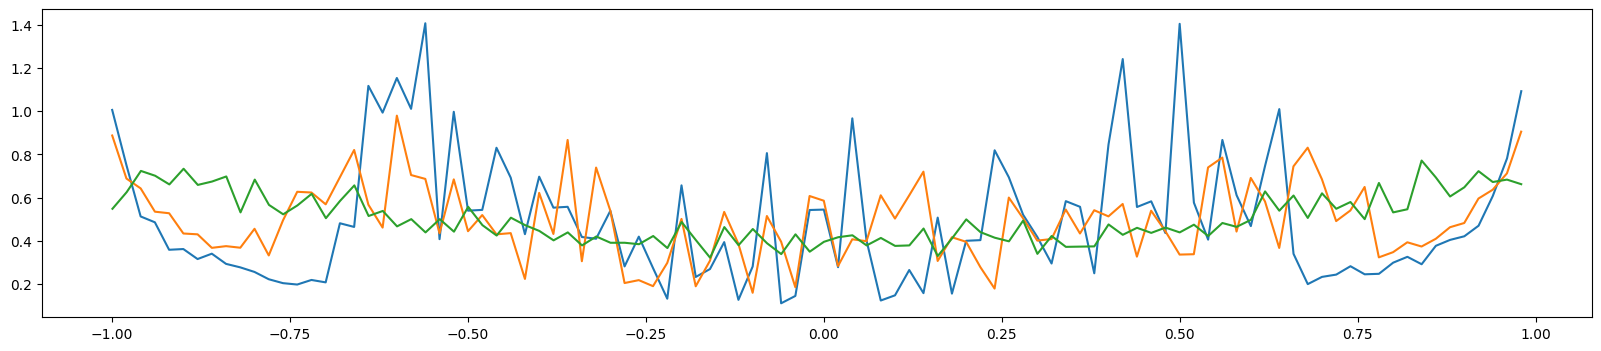

In [34]:
def saturation(out: Tensor) -> float:
    return (out.abs() > 0.97).float().mean()


figure(figsize=(20, 4))
legends = []
for i, (component, out) in enumerate(record.items()):
    if isinstance(component, Functional):
        name = component.describe()
        print(f"layer {i:>3} {name}: mean {out.mean(): .4f}, std {out.std(): .4f}, saturation {saturation(out): .2%}")
        hy, hx = histogram(out, density=True)
        plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")

In [35]:
figure(figsize=(20, 4))
legends = []
for i, (component, out) in enumerate(record.items()):
    if isinstance(component, Functional):
        name = component.describe()
        print(f"layer {i:>3} {name}: mean {out.grad.mean(): .4f}, std {out.grad.std(): .4f}")
        hy, hx = histogram(out.grad, density=True)
        plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({name})")

AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

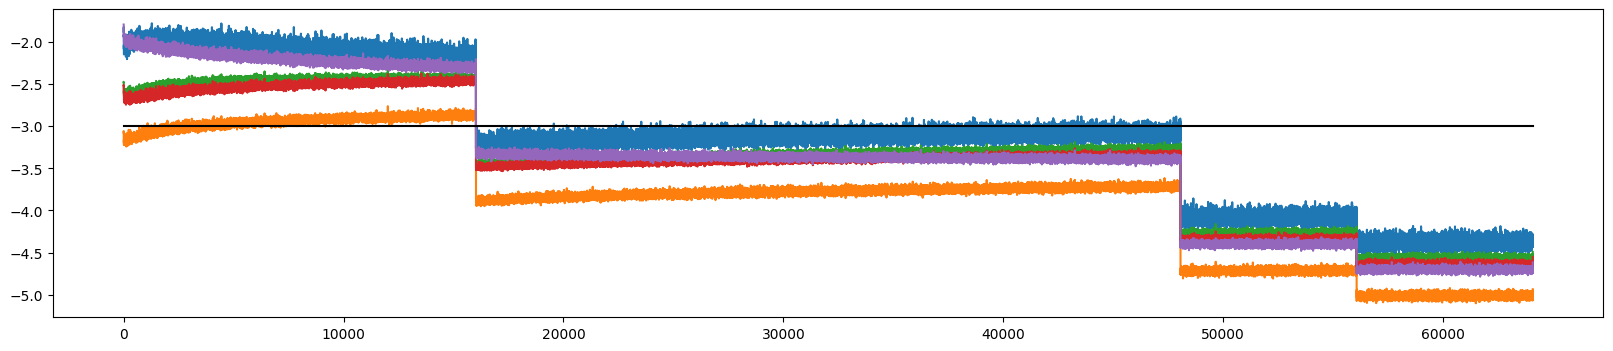

In [41]:
figure(figsize=(20, 4))
legends = []
for i, p in enumerate(wavenet.parameters()):
    if p.ndim == 2:
        plot([learning_record.update_ratios[j][i] for j in range(len(learning_record.update_ratios))])
        legends.append(f"param {i}")
plot([0, len(learning_record.update_ratios)], [-3, -3], "k")